In [1]:
library(ReactomePA)
library(org.Sc.sgd.db)
library(clusterProfiler)

Loading required package: DOSE

DOSE v3.0.10  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609

ReactomePA v1.18.1  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, par

In [3]:
file <- "yeast_reactome"

# ont <- "BP"
e_sg <- 0.3
e_en <- 0.2

db <- org.Sc.sgd.db
# mapping <- "org.Sc.sgd.db"
# ID <- "ENSEMBL"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/%s_hierarchy_communities_%s_%s", file, e_sg, e_en))

In [4]:
generateMap <- function(filename){
    map <- as.matrix(read.csv(filename, sep=",", header = F))
    communities <- map[,1]
    map <- map[,2:ncol(map)]
    rownames(map) <- communities
    colnames(map) <- communities
    return (map)
}

#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

##convert all genes to ENTREZID
conversion <- select(db, allGenes, "ENTREZID", "UNIPROT")
conversion <- subset(conversion, !duplicated(conversion$UNIPROT))
allGenes <- conversion$ENTREZID

#shortest path files
shortestPathFiles  <- list.files(pattern="*shortest_path*")

#shortest paths list
shortestPaths <- sapply(shortestPathFiles, generateMap)
names(shortestPaths) <- sapply(names(shortestPaths), function(name) strsplit(name, "_")[[1]][[1]])

#communitiy assignemtns
assignments <- as.matrix(read.csv("assignment_matrix.csv", sep=",", header=F, colClasses="character"))
assignments[assignments == ""] <- NA 
rownames(assignments) <- allGenes
colnames <- sapply(1:ncol(assignments), function(i) as.character(i - 1))
colnames(assignments) <- colnames
    
#filter out genes with no ENTREZID
assignments <- assignments[!is.na(rownames(assignments)),]
    
#all ORF identifers in org.Sc.sgd.db converted to EntrezID
allGenesInDB <- select(db, keys(db), "ENTREZID", "ORF")$ENTREZID
allGenesInDB <- allGenesInDB[!is.na(allGenesInDB)]
    
#communities detected
communities <- unique(as.character(assignments))
communities <- communities[communities != ""]
communities <- sort(communities)

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [5]:
getDepth <- function(com) {
    return(which(apply(assignments, 2, function(i) any(i == com))))
}

getGenes <- function(com){
    depth <- getDepth(com)
    return(names(which(assignments[, depth] == com)))
}

getSubCommunities <- function(com){
    depth <- getDepth(com)
    genesInCommunity <- subset(assignments, assignments[,depth] == com)
    if (depth < ncol(genesInCommunity)){
        return(as.character(unique(genesInCommunity[,depth + 1])))
    } else {
        return (NULL)
    }
    
}

getSuperCommunity <- function(com){
    depth <- getDepth(com)
    genesInCommunity <- subset(assignments, assignments[,depth] == com)
    return(as.character(unique(genesInCommunity[,depth - 1])))
}

getShortestPath <- function(com){
    return (try(shortestPaths[[com]]))
}
                       
getNeighbours <- function(com){
    
    superCommunity <- getSuperCommunity(com)
    superCommunityMap <- getShortestPath(superCommunity)
    v <- superCommunityMap[com, ] == 1
    return (names(v[v]))
    
}

In [6]:
genesInCommunities <- sapply(communities, function(i) getGenes(i))

In [7]:
communities

[1] "01"             "01-01"          "01-01-01"       "01-01-01-01"   
  [5] "01-01-01-02"    "01-01-01-03"    "01-01-01-04"    "01-01-01-05"   
  [9] "01-01-01-06"    "01-01-01-07"    "01-01-01-08"    "01-01-01-09"   
 [13] "01-01-01-10"    "01-01-02"       "01-01-02-01"    "01-01-02-02"   
 [17] "01-01-02-02-01" "01-01-02-02-02" "01-01-02-02-03" "01-01-02-03"   
 [21] "01-01-02-04"    "01-01-02-05"    "01-01-02-05-01" "01-01-02-05-02"
 [25] "01-01-02-05-03" "01-01-02-05-04" "01-01-03"       "01-01-03-01"   
 [29] "01-01-03-02"    "01-01-03-02-01" "01-01-03-02-02" "01-01-03-02-03"
 [33] "01-01-03-03"    "01-01-03-03-01" "01-01-03-03-02" "01-01-03-03-03"
 [37] "01-01-03-04"    "01-01-04"       "01-01-04-01"    "01-01-04-01-01"
 [41] "01-01-04-01-02" "01-01-04-01-03" "01-01-04-01-04" "01-01-04-01-05"
 [45] "01-01-04-01-06" "01-01-04-02"    "01-01-04-03"    "01-01-04-03-01"
 [49] "01-01-04-03-02" "01-01-04-03-03" "01-01-04-04"    "01-01-04-04-01"
 [53] "01-01-04-04-02" "01-01-04-04-03" "01-02"          "01-02-01"      
 [57] "01-02-02"       "01-02-03"       "01-02-04"       "01-02-04-01"   
 [61] "01-02-04-02"    "01-02-04-03"    "01-02-04-04"    "01-02-04-05"   
 [65] "01-02-05"       "01-02-05-01"    "01-02-05-02"    "01-02-05-03"   
 [69] "01-03"          "01-04"          "01-04-01"       "01-04-01-01"   
 [73] "01-04-01-02"    "01-04-01-03"    "01-04-01-04"    "01-04-01-05"   
 [77] "01-04-01-06"    "01-04-01-07"    "01-04-01-08"    "01-04-01-09"   
 [81] "01-04-01-10"    "01-04-02"       "01-04-02-01"    "01-04-02-01-01"
 [85] "01-04-02-01-02" "01-04-02-01-03" "01-04-02-01-04" "01-04-02-01-05"
 [89] "01-04-02-02"    "01-04-02-02-01" "01-04-02-02-02" "01-04-02-02-03"
 [93] "01-04-02-03"    "01-04-02-04"    "01-04-02-04-01" "01-04-02-04-02"
 [97] "01-04-02-04-03" "01-04-03"       "01-04-04"       "01-04-04-01"   
[101] "01-04-04-02"    "01-04-04-03"    "01-04-04-03-01" "01-04-04-03-02"
[105] "01-04-04-03-03" "01-04-04-04"    "01-05"          "01-05-01"      
[109] "01-05-02"       "01-05-03"       "01-05-04"       "01-05-05"      
[113] "01-05-06"

In [8]:
length(communities)

[1] 113

In [9]:
lengths(genesInCommunities)

01          01-01       01-01-01    01-01-01-01    01-01-01-02 
          1131            284             63              5             15 
   01-01-01-03    01-01-01-04    01-01-01-05    01-01-01-06    01-01-01-07 
             3              9              5              9              4 
   01-01-01-08    01-01-01-09    01-01-01-10       01-01-02    01-01-02-01 
             5              7              1             90             21 
   01-01-02-02 01-01-02-02-01 01-01-02-02-02 01-01-02-02-03    01-01-02-03 
            22              9              8              5             12 
   01-01-02-04    01-01-02-05 01-01-02-05-01 01-01-02-05-02 01-01-02-05-03 
            18             17              7              4              5 
01-01-02-05-04       01-01-03    01-01-03-01    01-01-03-02 01-01-03-02-01 
             1             65             10             22              7 
01-01-03-02-02 01-01-03-02-03    01-01-03-03 01-01-03-03-01 01-01-03-03-02 
             8              7             20              8              6 
01-01-03-03-03    01-01-03-04       01-01-04    01-01-04-01 01-01-04-01-01 
             6             13             66             21              4 
01-01-04-01-02 01-01-04-01-03 01-01-04-01-04 01-01-04-01-05 01-01-04-01-06 
             7              2              4              3              1 
   01-01-04-02    01-01-04-03 01-01-04-03-01 01-01-04-03-02 01-01-04-03-03 
            12             18              5              7              6 
   01-01-04-04 01-01-04-04-01 01-01-04-04-02 01-01-04-04-03          01-02 
            15              6              5              4            170 
      01-02-01       01-02-02       01-02-03       01-02-04    01-02-04-01 
            43             55             34             13              2 
   01-02-04-02    01-02-04-03    01-02-04-04    01-02-04-05       01-02-05 
             4              5              1              1             25 
   01-02-05-01    01-02-05-02    01-02-05-03          01-03          01-04 
             7              9              9            358            221 
      01-04-01    01-04-01-01    01-04-01-02    01-04-01-03    01-04-01-04 
            68              6             10              9              9 
   01-04-01-05    01-04-01-06    01-04-01-07    01-04-01-08    01-04-01-09 
             6              4             10              4              9 
   01-04-01-10       01-04-02    01-04-02-01 01-04-02-01-01 01-04-02-01-02 
             1             54             16              3              3 
01-04-02-01-03 01-04-02-01-04 01-04-02-01-05    01-04-02-02 01-04-02-02-01 
             4              5              1             17              4 
01-04-02-02-02 01-04-02-02-03    01-04-02-03    01-04-02-04 01-04-02-04-01 
             7              6             10             11              4 
01-04-02-04-02 01-04-02-04-03       01-04-03       01-04-04    01-04-04-01 
             4              3             51             48             16 
   01-04-04-02    01-04-04-03 01-04-04-03-01 01-04-04-03-02 01-04-04-03-03 
             9             15              7              5              3 
   01-04-04-04          01-05       01-05-01       01-05-02       01-05-03 
             8             98             18             23             29 
      01-05-04       01-05-05       01-05-06 
            10             10              8

In [ ]:
enrichmentResults <- sapply(genesInCommunities, 
                            function (i) enrichPathway(gene = i, universe = allGenesInDB, organism = "yeast"))
names(enrichmentResults) <- communities

No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...
No gene can be mapped....
--> return NULL...


In [ ]:
x <- enrichmentResults[["01-05"]]

In [ ]:
nrow(as.data.frame(x))

In [ ]:
barplot(x, showCategory=10, title = "Top Enriched Pathways")

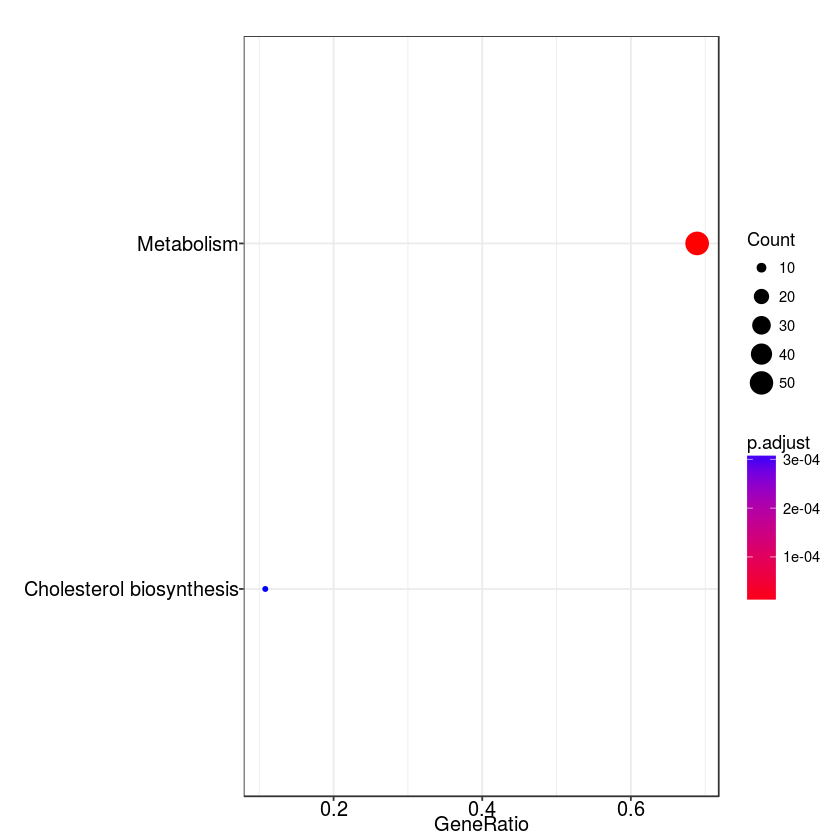

In [13]:
dotplot(x, showCategory=15)

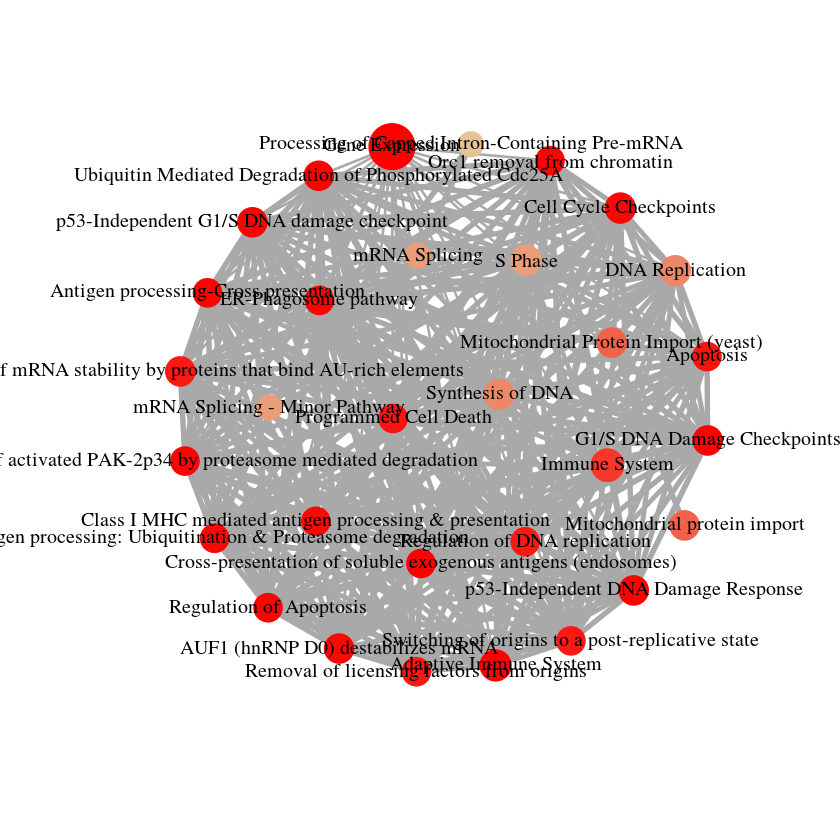

In [24]:
enrichMap(x, layout=igraph::layout.kamada.kawai, vertex.label.cex = 1)

In [13]:
numbersOfEnrichedPathways <- sapply(enrichmentResults, function(i) nrow(as.data.frame(i)))
enrichedCommunities <- genesInCommunities[numbersOfEnrichedPathways > 0]

In [14]:
res <- compareCluster(enrichedCommunities, 
                      fun="enrichPathway", universe = allGenesInDB, organism = "yeast")

png(filename=sprintf("community_pathway_enrichment_all_communities.png"), width=1500)
plot(res)
dev.off()

png 
  2

In [24]:
plotPathwayEnrichments <- function(community){
    
    subCommunities <- getSubCommunities(community)
    
    if (!is.null(subCommunities) && !any(is.na(subCommunities) > 0)) {

        communitiesOfInterest <- c(community, subCommunities)
        print(communitiesOfInterest)
        genesOfInterest <- enrichedCommunities[communitiesOfInterest]
        genesOfInterest <- genesOfInterest[!is.na(names(genesOfInterest))]
        print (genesOfInterest)
        
        if (length(genesOfInterest) > 2) {
            res <- compareCluster(genesOfInterest,
            fun="enrichPathway", universe = allGenesInDB, organism = "yeast")

            png(filename=sprintf("community_pathway_enrichment_%s.png", community), width=500 + length(genesOfInterest) * 150)
            print(plot(res))
            dev.off()
        } 
        
    }

}

In [ ]:
sapply(communities, plotPathwayEnrichments)

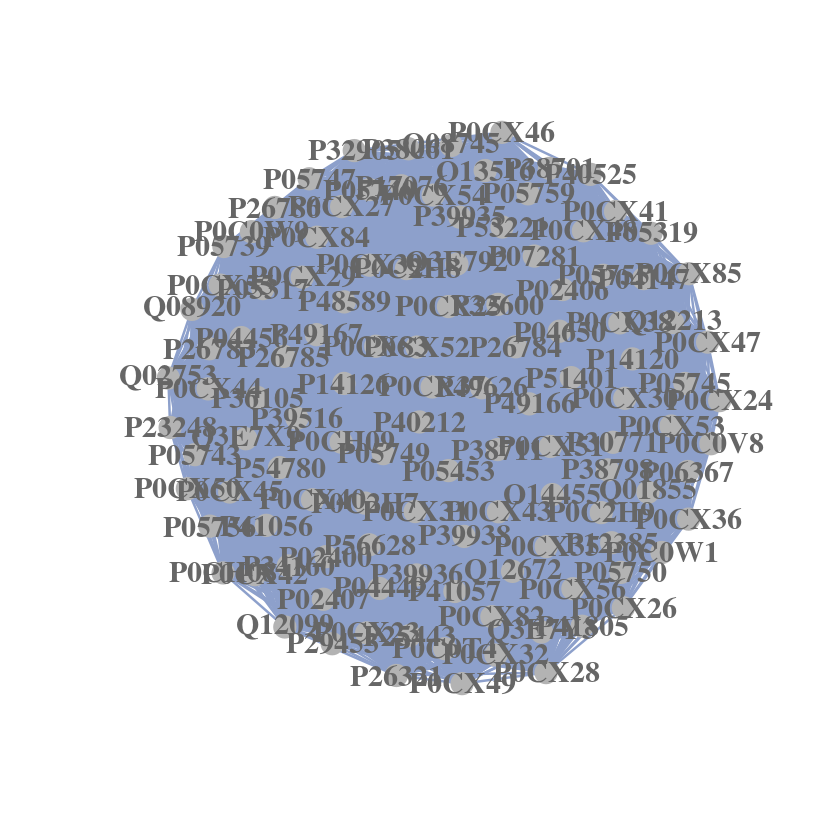

In [220]:
viewPathway(pathName = "Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC)", 
            organism = "yeast", readable = F)